## Initial setup

In [7]:
import Drone
from configurations import defaultConfig 
import numpy as np
from ConvexMotionPlanning import TrajGen 
from plottingFunctions import state_plots_command


In [5]:
# Drone instantiation
config = defaultConfig()
config.numObstacles = 4
drone = Drone.Drone(config, config)

# Parameters
thrustCommandVal = 4.4
refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))
iterations = 2000
iter = 0
pathDist = 100
stateRef = np.hstack(([0,50], refStates))
drone.reset(stateRef)

# Data
traj = np.zeros((7,iterations))
elvActual = np.zeros(iterations)
thrustCommand = np.zeros(iterations)+thrustCommandVal
stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
elivCommand = np.zeros(iterations) + elivCommandRef
xCommand = np.zeros(iterations)
yCommand = np.zeros(iterations)
refCommand = np.zeros((iterations, 4))
refCommand[0] = refStates

# Main loop
for iter in range(0, iterations):
    action = [thrustCommand[iter], elivCommand[iter], refCommand[iter, :]] 
    observation, grid, reward, terminated = drone.step(action)
    traj[:,iter] = np.hstack((drone.plant.state,drone.plant.time))
    elvActual[iter] = drone.delta_e_actual
    if(iter%pathDist == 0):
        thrustCommand, elivCommand, xCommand, yCommand, refCommand = TrajGen(drone, grid, thrustCommand, elivCommand, xCommand, yCommand, refStates, refCommand, thrustCommandVal,elivCommandRef, iterations, iter)


     pcost       dcost       gap    pres   dres
 0:  2.9145e+03 -2.5308e+05  3e+05  8e-02  5e+02
 1:  9.2127e+02 -8.8167e+04  9e+04  2e-02  1e+02
 2:  1.0460e+03 -8.4330e+04  9e+04  2e-02  1e+02
 3:  1.0992e+03 -6.0599e+04  6e+04  1e-02  6e+01
 4:  1.4384e+03 -2.3036e+04  2e+04  1e-04  6e-01
 5:  1.3192e+03 -7.5560e+02  2e+03  8e-06  5e-02
 6:  1.3147e+03  1.2899e+03  2e+01  9e-08  6e-04
 7:  1.3146e+03  1.3144e+03  2e-01  9e-10  6e-06
 8:  1.3146e+03  1.3146e+03  2e-03  9e-12  6e-08
 9:  1.3146e+03  1.3146e+03  2e-05  9e-14  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.3194e+03 -2.5396e+05  3e+05  6e-02  3e+02
 1:  6.9920e+02 -4.3829e+04  5e+04  9e-03  4e+01
 2:  7.2891e+02 -4.0496e+04  4e+04  7e-03  3e+01
 3:  9.5476e+02 -2.2789e+04  2e+04  7e-05  3e-01
 4:  8.0919e+02  1.1809e+02  7e+02  1e-06  6e-03
 5:  8.0681e+02  7.9986e+02  7e+00  1e-08  6e-05
 6:  8.0679e+02  8.0672e+02  7e-02  1e-10  6e-07
 7:  8.0679e+02  8.0679e+02  7e-04  1e-12  6e-0

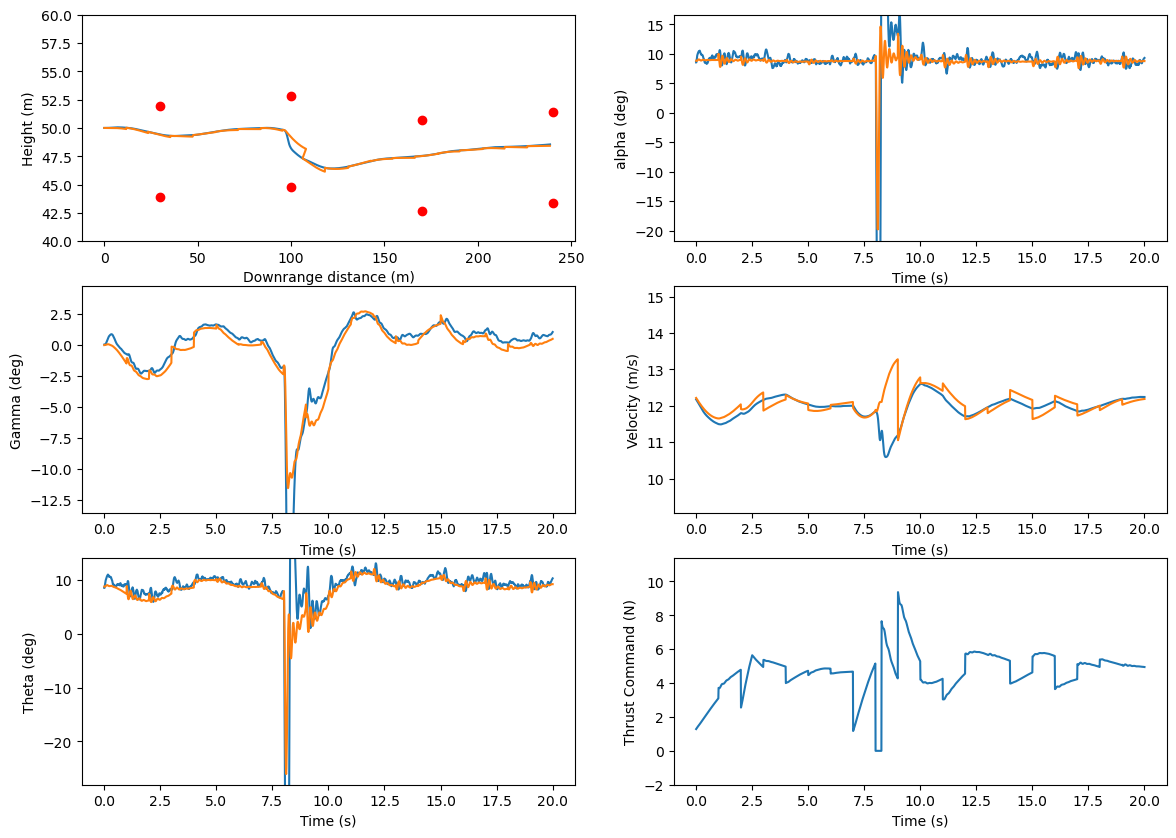

In [17]:
import importlib
import plottingFunctions
importlib.reload(plottingFunctions)
plottingFunctions.state_plots_command(traj,thrustCommand,xCommand, yCommand, elivCommand,elvActual, refCommand, drone)